# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это  изменить!)  

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [1]:
pip install matplotlib pandas nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import logging
import os
import shutil
from google.colab import drive

import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

import gensim

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

from gensim.models import Word2Vec

In [4]:
from nltk.tokenize import word_tokenize


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) 

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'Colab Notebooks')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

INFO:__main__:Инициализировали логгер
INFO:__main__:Подключили диск


Mounted at /content/drive


INFO:__main__:Содержимое директории /content/drive/MyDrive/Colab Notebooks: ['Copy of Fine-Tune-BERT-for-Text-Classification-with-TensorFlow.ipynb', 'lenta_sample.csv', 'Копия блокнота "Part_01_ML_intro.ipynb"', 'homework_RNN.ipynb"', 'homework_transformers.ipynb"', 'Sircumstant_classifyer.ipynb', 'wiki_data.txt', 'Sircumstant_classifyer v.1.0.ipynb"', 'Argument_adjunct_preprocessing.ipynb', 'Argument_adjunct_classifyer.ipynb', 'L_Argument_adjunct_classifyer.ipynb', 'labeled.csv', 'homework_embeddings.ipynb']


In [70]:
file = os.path.join(root_data_dir, 'wiki_data.txt')

In [71]:
wiki = open(file).read().split('\n')

In [72]:
len(wiki)

20003

In [73]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 120.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=599d1189da1803ed28506b6ec5874461178efd4bac69ca429780b884809041ea
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [76]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.10/dist-packages/pymorphy2_dicts_ru/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [77]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    lemmas = list()
    for word in tokens:
        p = morph.parse(word)[0]
        lemmas.append(p.normal_form)
    return lemmas

In [78]:
from tqdm import tqdm

In [79]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

100%|██████████| 20003/20003 [15:53<00:00, 20.98it/s]


In [80]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [81]:
id2word = {i:word for word, i in word2id.items()}

In [82]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [83]:
vocab_size = len(id2word)

# **Skip-gram**

In [84]:
def gen_batches_sg(sentences, window, batch_size=500):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [85]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [86]:
model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=500,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
3000/3000 [==============================] - 164s 54ms/step - loss: 0.4985 - accuracy: 0.7598 - val_loss: 0.5154 - val_accuracy: 0.7506
Epoch 2/3
3000/3000 [==============================] - 164s 55ms/step - loss: 0.4424 - accuracy: 0.8012 - val_loss: 0.4928 - val_accuracy: 0.7863
Epoch 3/3
3000/3000 [==============================] - 171s 57ms/step - loss: 0.4429 - accuracy: 0.8042 - val_loss: 0.5697 - val_accuracy: 0.7532


In [87]:
embeddings1 = model.layers[2].get_weights()[0]

In [88]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [89]:
most_similar('город', embeddings1)

['город',
 'около',
 'южный',
 'часть',
 'находиться',
 'западный',
 'участок',
 'порядок',
 'км',
 'центр']

In [90]:
most_similar('профессор', embeddings1)

['профессор',
 'г',
 'кафедра',
 'должность',
 'окончить',
 'факультет',
 'заведовать',
 'институт',
 'год',
 'курс']

In [91]:
most_similar('компьютер', embeddings1)

['компьютер',
 'противолодочный',
 'обложка',
 'голод',
 'предприниматься',
 'александра',
 'взаимный',
 'з',
 'бывать',
 'мемориальный']

Для слов "город" и "профессор" действительно получилось найти близкие по смыслу слова. Для "компьютер" результаты значительно хуже. 

# **C-Bow**

In [92]:
def gen_batches_cbow(sentences, window = 6, batch_size=500):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [93]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=500,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
3000/3000 [==============================] - 224s 74ms/step - loss: 0.4121 - accuracy: 0.8160 - val_loss: 0.4049 - val_accuracy: 0.8260
Epoch 2/3
3000/3000 [==============================] - 206s 69ms/step - loss: 0.3482 - accuracy: 0.8529 - val_loss: 0.3218 - val_accuracy: 0.8673
Epoch 3/3
3000/3000 [==============================] - 207s 69ms/step - loss: 0.3038 - accuracy: 0.8739 - val_loss: 0.2917 - val_accuracy: 0.8836


In [95]:
embeddings = model.layers[2].get_weights()[0]

In [96]:
most_similar('город', embeddings)

['город',
 'где',
 'они',
 'часть',
 'он',
 'который',
 'её',
 'район',
 'первый',
 'крупный']

In [97]:
most_similar('профессор', embeddings)

['профессор',
 'доктор',
 'философия',
 'ф',
 'наука',
 'академик',
 'архитектор',
 'преподаватель',
 'инженер',
 '«история']

In [98]:
most_similar('компьютер', embeddings)

['компьютер',
 'размещение',
 'трёхмерный',
 'эксперимент',
 'оборудование',
 'экран',
 'установка',
 'ограничение',
 'лечение',
 'подходить']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [105]:
# !pip install gensim
import gensim
from gensim.models import Word2Vec

In [106]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    lemmas = list()
    for word in tokens:
        p = morph.parse(word)[0]
        lemmas.append(p.normal_form)
    return lemmas

In [107]:
file = os.path.join(root_data_dir, 'wiki_data.txt')

In [108]:
wiki = open(file).read().split('\n')

In [109]:
texts = [preprocess(text) for text in wiki]

# **Word2Ves gensim**

In [110]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=250, 
                             min_count=50, 
                             max_vocab_size=11000,
                             window=9,
                             epochs=9,
                             sg=0,
                             hs=1, 
                             sample=1e-4,
                             ns_exponent=0.95, 
                             cbow_mean=0)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.utils:pruned out 0 tokens with count <=1 (before 11186, after 11186)
INFO:gensim.utils:pruned out 6281 tokens with count <=2 (before 11187, after 4906)
INFO:gensim.utils:pruned out 6450 tokens with count <=3 (before 11023, after 4573)
INFO:gensim.utils:pruned out 6699 tokens with count <=4 (before 11079, after 4380)
INFO:gensim.utils:pruned out 6863 tokens with count <=5 (before 11054, after 4191)
INFO:gensim.utils:pruned out 7006 tokens with count <=6 (before 11061, after 4055)
INFO:gensim.utils:pruned out 7175 tokens with count <=7 (before 11151, after 3976)
INFO:gensim.utils:pruned out 7127 tokens with count <=8 (before 11026, after 3899)
INFO:gensim.utils:pruned out 7228 tokens with count <=9 (before 11032, after 3804)
INFO:gensim.utils:pruned out 7311 tokens with count <=10 (before 11055, after 3744)
INFO:gensim

In [111]:
w2v.wv.most_similar('город')

[('и', 0.6843292117118835),
 ('центр', 0.668544590473175),
 ('в', 0.6589821577072144),
 ('он', 0.6465439796447754),
 ('—', 0.6458922624588013),
 ('округ', 0.6280940771102905),
 ('на', 0.627242922782898),
 ('который', 0.6197815537452698),
 ('', 0.6194816827774048),
 ('расположить', 0.6158928275108337)]

In [112]:
w2v.wv.most_similar('профессор')

[('наука', 0.6335884928703308),
 ('университет', 0.6265956163406372),
 ('преподавать', 0.6239333152770996),
 ('преподаватель', 0.6195518970489502),
 ('кафедра', 0.59222412109375),
 ('доктор', 0.5893443822860718),
 ('г', 0.587348461151123),
 ('академик', 0.5687968730926514),
 ('и', 0.5631793737411499),
 ('институт', 0.5584172606468201)]

In [113]:
w2v.wv.most_similar('компьютер')

KeyError: ignored

In [114]:
w2v.wv.most_similar('церковь')

[('храм', 0.8191401958465576),
 ('собор', 0.7174171805381775),
 ('святой', 0.6468510031700134),
 ('часовня', 0.6366211175918579),
 ('богородица', 0.6182942390441895),
 ('православный', 0.6153858304023743),
 ('монастырь', 0.6109724640846252),
 ('католический', 0.6025855541229248),
 ('деревянный', 0.5745288133621216),
 ('освятить', 0.5688535571098328)]

In [115]:
w2v.wv.most_similar('река')

[('озеро', 0.7227383255958557),
 ('ручей', 0.6842154264450073),
 ('впадать', 0.6841840147972107),
 ('устье', 0.6695337891578674),
 ('приток', 0.669109582901001),
 ('исток', 0.6649820804595947),
 ('расположить', 0.6405476331710815),
 ('село', 0.6303327083587646),
 ('водохранилище', 0.6230842471122742),
 ('долина', 0.6192793846130371)]

Эта модель работает лучше, чем предыдущие, слова значительно ближе по контексту, более похожи. Но в этот раз слово "компьютер" в словаре не нашлось, хотя в предыдущих итерациях было в нём.

# **Fasttext gensim**

In [116]:
ft = gensim.models.FastText(texts, min_n=3, max_n=10)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 2454250 words, keeping 159659 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 5106475 words, keeping 262625 word types
INFO:gensim.models.word2vec:collected 262744 word types from a corpus of 5114884 raw words and 20003 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=5 retains 51398 unique words (19.56% of original 262744, drops 211346)', 'datetime': '2023-06-02T22:33:06.152185', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.107+-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=5 leaves 4803325 word corpus (93.91

In [117]:
ft.wv.most_similar("город")

[('ужгород', 0.9639153480529785),
 ('«город', 0.9610036015510559),
 ('город»', 0.9555705189704895),
 ('городе»', 0.9482086896896362),
 ('белгород', 0.9312699437141418),
 ('огород', 0.9288678765296936),
 ('городец', 0.9286567568778992),
 ('городня', 0.9189662933349609),
 ('городок', 0.917345404624939),
 ('китай-город', 0.9073127508163452)]

In [118]:
ft.wv.most_similar("профессор")

[('адъюнкт-профессор', 0.9750276803970337),
 ('«профессор', 0.9733209609985352),
 ('ассистент-профессор', 0.9536250829696655),
 ('профессура', 0.8998289108276367),
 ('физик', 0.8646581172943115),
 ('академикал»', 0.8384290337562561),
 ('академик', 0.8337711095809937),
 ('асессор', 0.8323731422424316),
 ('преподаватель', 0.8292263150215149),
 ('доктор', 0.8186699748039246)]

In [119]:
ft.wv.most_similar("студент")

[('студентка', 0.8605139851570129),
 ('тренер-преподаватель', 0.8303905129432678),
 ('преподаватель', 0.8264657258987427),
 ('студенок', 0.8090336918830872),
 ('эмитент', 0.7855080962181091),
 ('аспирант', 0.7763375043869019),
 ('учитель', 0.7733142375946045),
 ('пенсионер', 0.7650538682937622),
 ('профтехшкола', 0.7627951502799988),
 ('эксцентриситет', 0.754654586315155)]

In [120]:
ft.wv.most_similar("река")

[('шрека', 0.978700578212738),
 ('«река', 0.9742478132247925),
 ('бурека', 0.9683145880699158),
 ('берека', 0.9577885866165161),
 ('курека', 0.9482197165489197),
 ('фрека', 0.9456060528755188),
 ('брека', 0.938793420791626),
 ('бережок', 0.8770813941955566),
 ('берег', 0.8739312887191772),
 ('бурекас', 0.8611720204353333)]

Эта модель выдаёт одинаковые слова и другие падежные формы, чем близкие по значению к исходному. 

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [121]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.10/dist-packages/pymorphy2_dicts_ru/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [122]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    lemmas = list()
    for word in tokens:
        p = morph.parse(word)[0]
        lemmas.append(p.normal_form)
    return lemmas

In [123]:
file = os.path.join(root_data_dir, 'labeled.csv')

In [124]:
data = pd.read_csv(file)
data['preprocessed_text'] = data.comment.apply(preprocess)

In [125]:
vocab = Counter()

for text in data['preprocessed_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6309

In [126]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [127]:
X = []

for tokens in data['preprocessed_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
len(X)

14412

**SkipGram**

In [128]:
X_skip = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_skip = data.toxic.values

X_train_skip, X_valid_skip, y_train_skip, y_valid_skip = train_test_split(X_skip, y_skip, test_size=0.1)
weights = np.zeros((len(word2id), 300))

model_weights = embeddings

for id in id2word.keys(): 
    if id == 0:
        continue
    try:
        weights[id] = model_weights[id]
      
      
    except KeyError:
        continue
        weights[id] = model_weights[100000000] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

skip_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
skip_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
skip_classifier.fit(X_train_skip, y_train_skip, 
          validation_data=(X_valid_skip, y_valid_skip),
          batch_size=32,
         epochs=30)
  

Epoch 1/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6482 - accuracy: 0.6630 - val_loss: 0.6372 - val_accuracy: 0.6581
Epoch 2/30
406/406 [==============================] - 2s 6ms/step - loss: 0.6272 - accuracy: 0.6659 - val_loss: 0.6358 - val_accuracy: 0.6581
Epoch 3/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6259 - accuracy: 0.6659 - val_loss: 0.6356 - val_accuracy: 0.6581
Epoch 4/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6254 - accuracy: 0.6659 - val_loss: 0.6357 - val_accuracy: 0.6581
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6251 - accuracy: 0.6659 - val_loss: 0.6353 - val_accuracy: 0.6581
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6248 - accuracy: 0.6659 - val_loss: 0.6347 - val_accuracy: 0.6581
Epoch 7/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6245 - accuracy: 0.6659 - val_loss: 0.6343 - val_accuracy: 0.6581
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


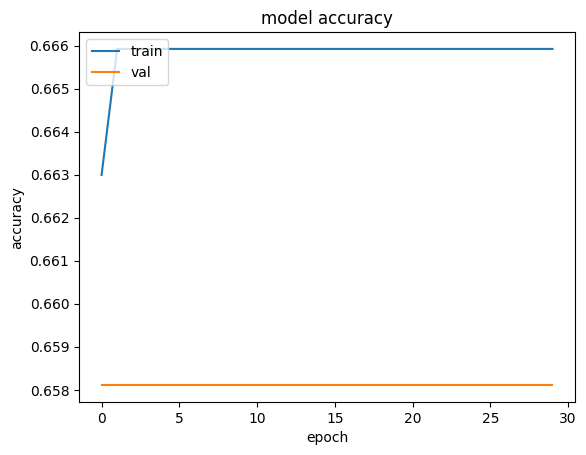

In [129]:
print(skip_classifier.history.history.keys())
acc4=skip_classifier.history.history['accuracy'][-1]
# summarize history for accuracy
plt.plot(skip_classifier.history.history['accuracy'])
plt.plot(skip_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Cbow**

In [130]:
X_cbow = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_cbow = data.toxic.values

X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(X_cbow, y_cbow, test_size=0.1)
weights = np.zeros((len(word2id), 300))

model_weights = embeddings1

for id in id2word.keys(): 
    if id == 0:
        continue
    try:
        weights[id] = model_weights[id]
      
      
    except KeyError:
        continue
        weights[id] = model_weights[100000000] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

cbow_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
cbow_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
cbow_classifier.fit(X_train_cbow, y_train_cbow, 
          validation_data=(X_test_cbow, y_test_cbow),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 3s 5ms/step - loss: 0.6596 - accuracy: 0.6598 - val_loss: 0.6235 - val_accuracy: 0.6949
Epoch 2/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6331 - accuracy: 0.6618 - val_loss: 0.6068 - val_accuracy: 0.6949
Epoch 3/30
406/406 [==============================] - 2s 6ms/step - loss: 0.6291 - accuracy: 0.6618 - val_loss: 0.6031 - val_accuracy: 0.6949
Epoch 4/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6285 - accuracy: 0.6618 - val_loss: 0.6021 - val_accuracy: 0.6949
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6283 - accuracy: 0.6618 - val_loss: 0.6016 - val_accuracy: 0.6949
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6281 - accuracy: 0.6618 - val_loss: 0.6012 - val_accuracy: 0.6949
Epoch 7/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6279 - accuracy: 0.6618 - val_loss: 0.6014 - val_accuracy: 0.6949
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


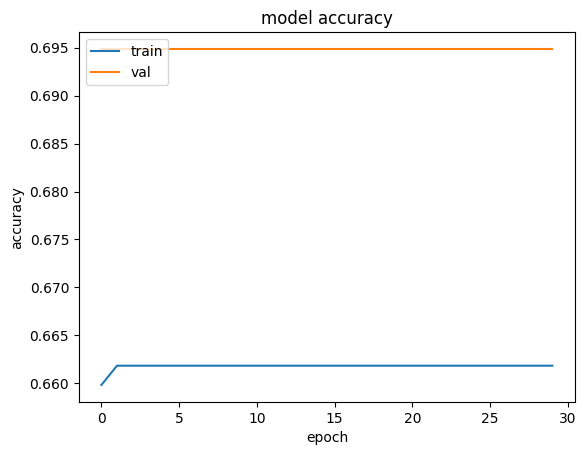

In [131]:
print(cbow_classifier.history.history.keys())
acc3=cbow_classifier.history.history['accuracy'][-1]

plt.plot(cbow_classifier.history.history['accuracy'])
plt.plot(cbow_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Word2Vec**

In [ ]:
X_skip = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_skip = data.toxic.values

X_train_skip, X_valid_skip, y_train_skip, y_valid_skip = train_test_split(X_skip, y_skip, test_size=0.1)
weights = np.zeros((len(word2id), 300))

model_weights = embeddings

for id in id2word.keys(): 
    if id == 0:
        continue
    try:
        weights[id] = model_weights[id]
      
      
    except KeyError:
        continue
        weights[id] = model_weights[100000000] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

skip_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
skip_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
skip_classifier.fit(X_train_skip, y_train_skip, 
          validation_data=(X_valid_skip, y_valid_skip),
          batch_size=32,
         epochs=30)
  

Epoch 1/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6482 - accuracy: 0.6630 - val_loss: 0.6372 - val_accuracy: 0.6581
Epoch 2/30
406/406 [==============================] - 2s 6ms/step - loss: 0.6272 - accuracy: 0.6659 - val_loss: 0.6358 - val_accuracy: 0.6581
Epoch 3/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6259 - accuracy: 0.6659 - val_loss: 0.6356 - val_accuracy: 0.6581
Epoch 4/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6254 - accuracy: 0.6659 - val_loss: 0.6357 - val_accuracy: 0.6581
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6251 - accuracy: 0.6659 - val_loss: 0.6353 - val_accuracy: 0.6581
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6248 - accuracy: 0.6659 - val_loss: 0.6347 - val_accuracy: 0.6581
Epoch 7/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6245 - accuracy: 0.6659 - val_loss: 0.6343 - val_accuracy: 0.6581
Epoch 

In [151]:
X_w2 = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=250)
y_w2 = data.toxic.values

X_train_w2, X_test_w2, y_train_w2, y_test_w2 = train_test_split(X_w2, y_w2, test_size=0.1)

weights = np.zeros((len(word2id), 250))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights[i] = w2v.wv['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(250,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=250, trainable=False, weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)



w2v_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
w2v_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

w2v_classifier.fit(X_train_w2, y_train_w2, 
          validation_data=(X_test_w2, y_test_w2),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 3ms/step - loss: 0.6495 - accuracy: 0.6647 - val_loss: 0.6354 - val_accuracy: 0.6671
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6233 - accuracy: 0.6649 - val_loss: 0.6323 - val_accuracy: 0.6671
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6203 - accuracy: 0.6649 - val_loss: 0.6324 - val_accuracy: 0.6671
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6193 - accuracy: 0.6649 - val_loss: 0.6321 - val_accuracy: 0.6671
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6184 - accuracy: 0.6649 - val_loss: 0.6315 - val_accuracy: 0.6671
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6175 - accuracy: 0.6649 - val_loss: 0.6312 - val_accuracy: 0.6671
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6166 - accuracy: 0.6649 - val_loss: 0.6303 - val_accuracy: 0.6671
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


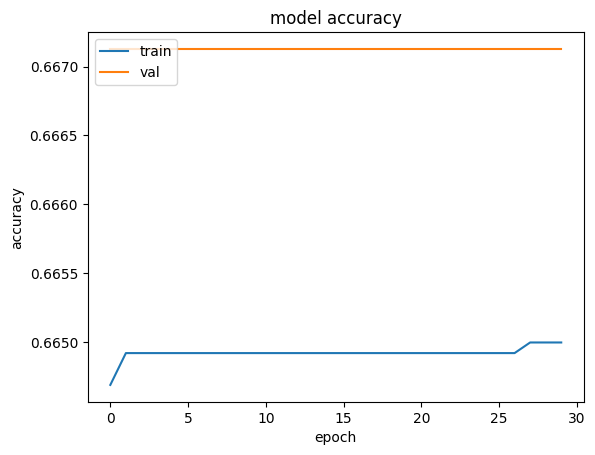

In [152]:
print(w2v_classifier.history.history.keys())
acc2=w2v_classifier.history.history['accuracy'][-1]
plt.plot(w2v_classifier.history.history['accuracy'])
plt.plot(w2v_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**FastText**

In [135]:

X_ft = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y_ft = data.toxic.values

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, y_ft, test_size=0.1)

weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights[i] = ft.wv['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(100,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

ft_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
ft_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

ft_classifier.fit(X_train_ft, y_train_ft, 
          validation_data=(X_test_ft, y_test_ft),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 3ms/step - loss: 0.6213 - accuracy: 0.6519 - val_loss: 0.6069 - val_accuracy: 0.6755
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5955 - accuracy: 0.6665 - val_loss: 0.5908 - val_accuracy: 0.6824
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5831 - accuracy: 0.6725 - val_loss: 0.5801 - val_accuracy: 0.6893
Epoch 4/30
406/406 [==============================] - 1s 2ms/step - loss: 0.5748 - accuracy: 0.6790 - val_loss: 0.5724 - val_accuracy: 0.7004
Epoch 5/30
406/406 [==============================] - 1s 2ms/step - loss: 0.5682 - accuracy: 0.6856 - val_loss: 0.5660 - val_accuracy: 0.7060
Epoch 6/30
406/406 [==============================] - 1s 2ms/step - loss: 0.5635 - accuracy: 0.6900 - val_loss: 0.5608 - val_accuracy: 0.7122
Epoch 7/30
406/406 [==============================] - 1s 2ms/step - loss: 0.5591 - accuracy: 0.6963 - val_loss: 0.5551 - val_accuracy: 0.7184
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


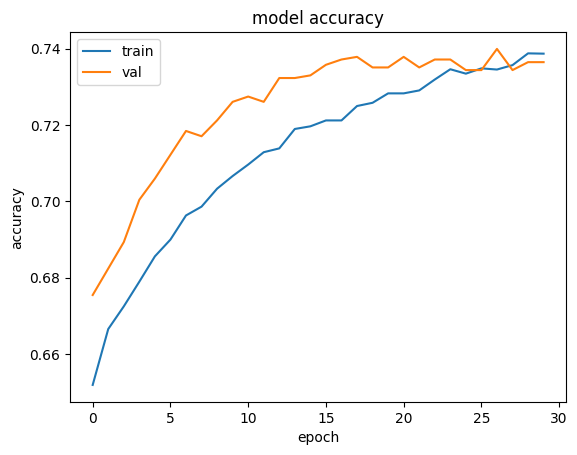

In [136]:
print(ft_classifier.history.history.keys())

acc1= ft_classifier.history.history['accuracy'][-1]
plt.plot(ft_classifier.history.history['accuracy'])
plt.plot(ft_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **ruwikiruscorpora_upos_cbow_300_5_2018**

In [138]:
model_file = os.path.join(root_data_dir, 'ruscorpora_upos_skipgram_300_5_2018.vec.gz')

In [155]:
import gzip
import shutil

In [157]:
model = gensim.models.KeyedVectors.load_word2vec_format(model_file, binary=False)

INFO:gensim.models.keyedvectors:loading projection weights from /content/drive/MyDrive/Colab Notebooks/ruscorpora_upos_skipgram_300_5_2018.vec.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (195071, 300) matrix of type float32 from /content/drive/MyDrive/Colab Notebooks/ruscorpora_upos_skipgram_300_5_2018.vec.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-06-02T23:24:52.041951', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.107+-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


In [158]:
model.most_similar('город_NOUN')

[('столица_NOUN', 0.7112625241279602),
 ('город_PROPN', 0.6893908381462097),
 ('городок_NOUN', 0.679741382598877),
 ('гектородар_NOUN', 0.6362420916557312),
 ('гороховец_PROPN', 0.6298733353614807),
 ('горнозаводск_PROPN', 0.6055487990379333),
 ('воротынск_PROPN', 0.6037364602088928),
 ('вязники_PROPN', 0.5986449718475342),
 ('пригород_NOUN', 0.5979276895523071),
 ('городоварищ_NOUN', 0.5973644852638245)]

In [169]:
map = os.path.join(root_data_dir,'ru-rnc.map')

In [170]:
mapping = {}

for line in open(map):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [189]:
from pymystem3 import Mystem
    
m = Mystem()

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        tokens.append(lemma+'_'+pos)

    return tokens
normalize_mystem('Лошадь')

['лошадь_S']

In [193]:
data['pos_tagged'] = data.comment.apply(normalize_mystem)

In [194]:
data.head()

,comment,toxic,preprocessed_text,pos_tagged
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд-то, за, что, дебил, бл]","[верблюд_S, то_PART, за_PR, что_SPRO, дебил_S,..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м...","[хохол_S, это_PART, отдушина_S, затюканый_A, р..."
2,Собаке - собачья смерть\n,1.0,"[собака, , собачий, смерть]","[собака_S, собачий_A, смерть_S]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск...","[страница_S, обновлять_V, дебил_S, это_SPRO, т..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч...","[ты_SPRO, не_PART, убеждать_V, страничный_A, п..."


In [195]:
vocab = Counter()

for text in data['pos_tagged']:
    vocab.update(text)

In [196]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6215

In [197]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [198]:
X = []

for tokens in data['pos_tagged']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [199]:
len(X)

14412

In [200]:
len(data.toxic.values)

14412

In [201]:
X_ru = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_ru = data.toxic.values

X_train_ru, X_test_ru, y_train_ru, y_test_ru = train_test_split(X_ru, y_ru, test_size=0.1)

weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = model[word]
    
    except KeyError:
        continue
        weights[i] = rus_v_model['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(300,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

ru_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
ru_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

ru_classifier.fit(X_train_ru, y_train_ru, 
          validation_data=(X_test_ru, y_test_ru),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 5s 11ms/step - loss: 0.6702 - accuracy: 0.6647 - val_loss: 0.6519 - val_accuracy: 0.6678
Epoch 2/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6453 - accuracy: 0.6648 - val_loss: 0.6380 - val_accuracy: 0.6678
Epoch 3/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6378 - accuracy: 0.6648 - val_loss: 0.6337 - val_accuracy: 0.6678
Epoch 4/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6357 - accuracy: 0.6648 - val_loss: 0.6322 - val_accuracy: 0.6678
Epoch 5/30
406/406 [==============================] - 3s 6ms/step - loss: 0.6349 - accuracy: 0.6648 - val_loss: 0.6315 - val_accuracy: 0.6678
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6344 - accuracy: 0.6648 - val_loss: 0.6307 - val_accuracy: 0.6678
Epoch 7/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6339 - accuracy: 0.6648 - val_loss: 0.6301 - val_accuracy: 0.6678
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


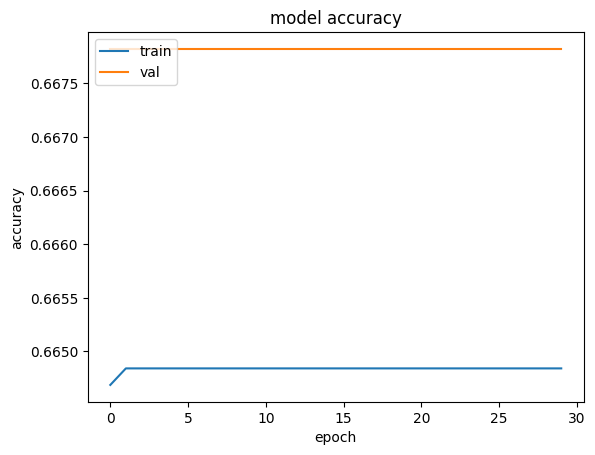

In [202]:
print(ru_classifier.history.history.keys())
acc5 = ru_classifier.history.history['accuracy'][-1]
# summarize history for accuracy
plt.plot(ru_classifier.history.history['accuracy'])
plt.plot(ru_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Вывод**

Самая "продуктивная" по метрикам модель - Fasttext.
При этом, самые близкие в "человеческой" оценке слова (те, которые действительно могут заменить в контексте слово "город") получаются у модели Rus Vectores, хотя машинный показатель обучения у неё довольно низкий.
В остальном, кажется, что модели быстро перестают учиться, застывая на отметке около 0.66. Возможно, это связано с предобработкой данных (а может, и с чем-то ещё).